### ■ NRBdMF case study
For both (1) prediction of the compound that produces a certain side effect and (2) prediction of the side effect that a certain compound produces, the NRBdMF concentrates the relationship with the known side effect at the top and the opposite relationship with the indication at the bottom.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

import sys
sys.path.append('C:/github/NRBdMF')
import nrbdmf # import proposed method
from Representative_Methods.methods import nrlmf # import traditional method
from _utils import performance_compare as pc

base_dir = 'C:/github/NRBdMF' # clone directory

In [2]:
#%% load data
df = pd.read_csv(base_dir + '/Data/646x499/se_ind_merge_table.csv',index_col=0)
drugMat = pd.read_csv(base_dir + '/Data/646x499/dtinet_646x646_sim.csv',index_col=0)
diseaseMat = pd.read_csv(base_dir + '/Data/646x499/do_499x499_sim.csv',index_col=0)

# for validation
ind_bi = pd.read_csv(base_dir + '/Data/raw_rel/ind_1423x2154_binary.csv',index_col=0)
se_bi = pd.read_csv(base_dir + '/Data/raw_rel/se_1429x4138_binary.csv',index_col=0)
use_ind = ind_bi[df.columns.tolist()].loc[df.index.tolist()]
use_se = se_bi[df.columns.tolist()].loc[df.index.tolist()]

drug2name = pd.read_pickle(base_dir + '/Data/tools/sider_cid2name.pkl')
list(drug2name.keys())[0]
name2pt = pd.read_pickle(base_dir + '/Data/tools/pt_name2cui.pkl')
pt2name = dict(zip(list(name2pt.values()),list(name2pt.keys())))

drugs = df.index.tolist()
diseases = df.columns.tolist()

ann_ind = [drug2name.get(k) for k in drugs]
ann_col = [pt2name.get(k) for k in diseases]

# renae all columns and rows
df.index = ann_ind
df.columns = ann_col

drugMat.index = ann_ind
drugMat.columns = ann_ind

diseaseMat.index = ann_col
diseaseMat.columns = ann_col

use_ind.index = ann_ind
use_ind.columns = ann_col

use_se.index = ann_ind
use_se.columns = ann_col

***
### ① Prediction of candidate compounds that cause specific side effects (Hypertension)
- Pregabalin and pramipexole, which are known to cause hypertension as a side effect, ranked high.
- Statins, which are known to have therapeutic effects on hypertension, have been pushed to the bottom of the forecast.

(0.7565631530349418, 0.6868386809696873) (0.7308987308987309, 0.28812459198979357)


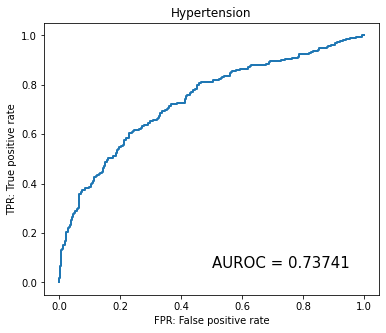

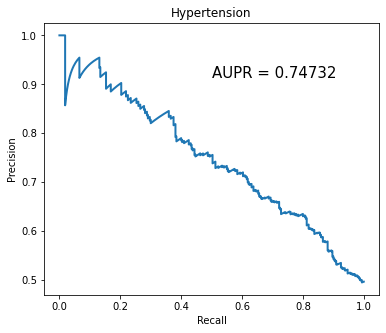

In [4]:
#%% cv_data for NRMMF
r = "Hypertension"

cv_data = defaultdict(list)
# create dataset
idx = df.columns.tolist().index(r)
intMat = np.array(df.T)
num_drugs,num_disease = intMat.T.shape
test_data = np.array([[k,j] for k in [idx] for j in range(num_drugs)],dtype=np.int32)
x,y = test_data[:,0], test_data[:,1]
test_label = intMat[x,y]
W = np.ones(intMat.shape)
W[x,y] = 0
cv_data[ann_col[idx]].append((W,test_data,test_label))

for W, test_data, test_label in cv_data[r]:
    model = nrbdmf.NRBdMF(K1=5,K2=5,num_factors=50,theta=1.0,lambda_d=0.625,lambda_t=0.625,alpha=0.1,beta=0.1, max_iter=5000,tolx=1e-5,positive_weight=0.1,negative_weight=0.1,missing_base=0,indicator=True,half_mask=False,verbose=False)
    model.fix_model(W, np.array(df).T, diseaseMat, drugMat, seed=123)
    posi_val,nega_val = model.ex_evaluation(test_data, test_label)
    print(posi_val,nega_val)
    
    # processing output
    pred_res = model.pred_res
    pred_res.index = df.index.tolist()
    se_label = use_se[r].tolist() # side effect binary label (before merging)
    pred_res['se_label'] = se_label
    ind_label = use_ind[r].tolist()
    pred_res['ind_label'] = ind_label
    pred_res['name'] = pred_res.index.tolist()
    pred_res = pred_res.sort_values('scores',ascending=False)

auroc, aupr = nrbdmf.calc_auc_aupr(y_true=pred_res['se_label'].tolist(), y_score=pred_res['scores'].tolist(),title=r)

***
#### Summary
- Known relationships with a label of 1 dominate the top of the prediction. 
- At the same time, the lower end of the side effects prediction is occupied by the interactions of indication, providing a highly interpretable prediction.

In [5]:
pred_res.head(15)

,scores,label,se_label,ind_label,name
paroxetine,0.128088,0,1,1,paroxetine
pregabalin,0.124531,1,1,0,pregabalin
ropinirole,0.121634,0,1,1,ropinirole
celecoxib,0.117924,0,1,1,celecoxib
pramipexole,0.116124,1,1,0,pramipexole
valdecoxib,0.113656,1,1,0,valdecoxib
methotrexate,0.111640,0,0,0,methotrexate
aripiprazole,0.106965,1,1,0,aripiprazole
naproxen,0.103946,1,1,0,naproxen
tramadol,0.103685,1,1,0,tramadol


In [6]:
pred_res.tail(15)

,scores,label,se_label,ind_label,name
ciclopirox,-0.088594,0,0,0,ciclopirox
metolazone,-0.088731,0,1,1,metolazone
polythiazide,-0.093155,-1,0,1,polythiazide
atorvastatin,-0.095875,-1,0,1,atorvastatin
diazoxide,-0.095883,0,1,1,diazoxide
warfarin,-0.097284,0,0,0,warfarin
prazosin,-0.107521,-1,0,1,prazosin
nitroglycerin,-0.107704,-1,0,1,nitroglycerin
famotidine,-0.112183,-1,0,1,famotidine
rosuvastatin,-0.117259,0,0,0,rosuvastatin


***
### ② Prediction of candidate side effects that would be caused by a specific compound (doxorubicin)
- Rash and constipation, well-known side effects of doxorubicin, are the top predicted.
- Conversely, it is lower predicted for indications related to Hodgkin's disease.

(0.8984715597271375, 0.689657867284643) (0.9166666666666666, 0.34600217593577115)


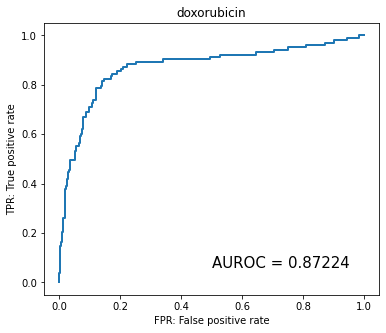

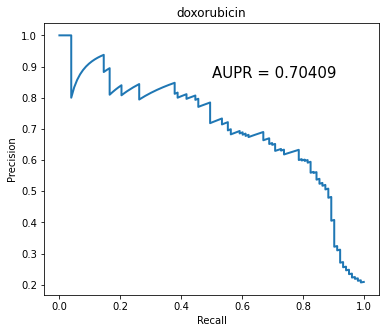

In [7]:
#%% cv_data for NRMMF
r = "doxorubicin"

cv_data = defaultdict(list)
# create dataset
idx = df.index.tolist().index(r)
intMat = np.array(df)
num_drugs,num_disease = intMat.T.shape
test_data = np.array([[k,j] for k in [idx] for j in range(num_drugs)],dtype=np.int32)
x,y = test_data[:,0], test_data[:,1]
test_label = intMat[x,y]
W = np.ones(intMat.shape)
W[x,y] = 0
cv_data[ann_ind[idx]].append((W,test_data,test_label))


for W, test_data, test_label in cv_data[r]:
    """
    set the optimized hyperparameter with 5 times 10-folds cross validation (CVS2)
    """
    model = nrbdmf.NRBdMF(K1=5,K2=5,num_factors=50,theta=1.0,lambda_d=0.625,lambda_t=0.625,alpha=0.1,beta=0.1, max_iter=5000,tolx=1e-5,positive_weight=0.1,negative_weight=0.1,missing_base=0,indicator=True,half_mask=False,verbose=False)
    model.fix_model(W, np.array(df), drugMat, diseaseMat, seed=123)
    posi_val,nega_val = model.ex_evaluation(test_data, test_label)
    print(posi_val,nega_val)
    
    # processing output
    pred_res = model.pred_res
    pred_res.index = df.columns.tolist()
    se_label = use_se.loc[r].tolist() # side effect binary label (before merging)
    pred_res['se_label'] = se_label
    ind_label = use_ind.loc[r].tolist()
    pred_res['ind_label'] = ind_label
    pred_res['name'] = pred_res.index.tolist()
    pred_res = pred_res.sort_values('scores',ascending=False)

auroc, aupr = nrbdmf.calc_auc_aupr(y_true=pred_res['se_label'].tolist(), y_score=pred_res['scores'].tolist(),title=r)



In [8]:
pred_res.head(15)

,scores,label,se_label,ind_label,name
Rash,0.990499,1,1,0,Rash
Constipation,0.981601,1,1,0,Constipation
Dermatitis,0.977036,1,1,0,Dermatitis
Alopecia,0.957277,1,1,0,Alopecia
Angioedema,0.944795,0,0,0,Angioedema
Thrombocytopenia,0.944043,1,1,0,Thrombocytopenia
Leukopenia,0.939247,1,1,0,Leukopenia
Hypersensitivity,0.917137,0,1,1,Hypersensitivity
Agranulocytosis,0.916272,1,1,0,Agranulocytosis
Photosensitivity reaction,0.909092,1,1,0,Photosensitivity reaction


In [9]:
pred_res.tail(15)

,scores,label,se_label,ind_label,name
Malaria,-0.174484,0,0,0,Malaria
Ankylosing spondylitis,-0.180141,0,0,0,Ankylosing spondylitis
Ocular hypertension,-0.187628,0,0,0,Ocular hypertension
Essential hypertension,-0.209128,0,0,0,Essential hypertension
Acquired immunodeficiency syndrome,-0.212825,-1,0,1,Acquired immunodeficiency syndrome
Non-small cell lung cancer,-0.237343,-1,0,1,Non-small cell lung cancer
Schizoaffective disorder,-0.246638,0,0,0,Schizoaffective disorder
Breast cancer,-0.302441,-1,0,1,Breast cancer
Immunodeficiency,-0.308387,0,1,1,Immunodeficiency
Cervix carcinoma,-0.315121,0,0,0,Cervix carcinoma
